<a href="https://colab.research.google.com/github/marsggbo/hyperbox/blob/master/examples/DARTS_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies and Import Modules

You shoud **restart/rerun** the runtime after running the following pip commands.

In [ ]:
# !pip install hyperbox==1.3.2
!pip uninstall -y hyperbox
!pip install git+https://github.com/marsggbo/hyperbox.git
!pip install pytorch-lightning==1.8.6

Found existing installation: hyperbox 1.3.2
Uninstalling hyperbox-1.3.2:
  Successfully uninstalled hyperbox-1.3.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/marsggbo/hyperbox.git to /tmp/pip-req-build-q1ivpgvv
  Running command git clone --filter=blob:none --quiet https://github.com/marsggbo/hyperbox.git /tmp/pip-req-build-q1ivpgvv
  Resolved https://github.com/marsggbo/hyperbox.git to commit c1ad89b0bc7580d4941defce3991c1fc8e31b978
  Preparing metadata (setup.py) ... done
  Created wheel for hyperbox: filename=hyperbox-1.3.2-py3-none-any.whl size=570519 sha256=2ddcd4b9bcda7dd45e8cde72568b75d2867ce5116c1bd00a9e4a466b12c07334
  Stored in directory: /tmp/pip-ephem-wheel-cache-zlfr4a7_/wheels/11/85/0e/b10497ae97fe28671898cd463a0d5437a6eb857e47e81c2d80
Successfully built hyperbox


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install --upgrade pygments rich

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms

from hyperbox.mutables import spaces, ops
from hyperbox.mutator import DartsMutator
from hyperbox.networks.base_nas_network import BaseNASNetwork


[2023-02-01 04:22:20] [INFO] [/usr/local/lib/python3.8/dist-packages/hyperbox/utils/logger.py:27 (hyperbox.utils.logger)] Logger is configured: <loguru.logger handlers=[(id=1, level=20, sink=stderr), (id=2, level=20, sink='/content/exp.log')]> 139696350142672
[2023-02-01 04:22:20] [INFO] [/usr/local/lib/python3.8/dist-packages/hyperbox/utils/logger.py:27 (hyperbox.utils.logger)] Logger is configured: <loguru.logger handlers=[(id=3, level=20, sink=stderr), (id=4, level=20, sink='/content/exp.log')]> 139696350142672


# Prepare CIFAR10 Datasets

In [ ]:

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

batch_size = 64

all_train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
length_set = len(all_train_set)
len_train_set = length_set // 2
len_val_set = length_set - len_train_set
train_set, val_set = torch.utils.data.random_split(all_train_set, [len_train_set, len_val_set])
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=valid_transform)

print(f"length of train/val/test set: {len_train_set}/{len_val_set}/{len(test_set)}")

all_train_loader = torch.utils.data.DataLoader(all_train_set, batch_size=batch_size, shuffle=True, num_workers=2)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
length of train/val/test set: 25000/25000/10000


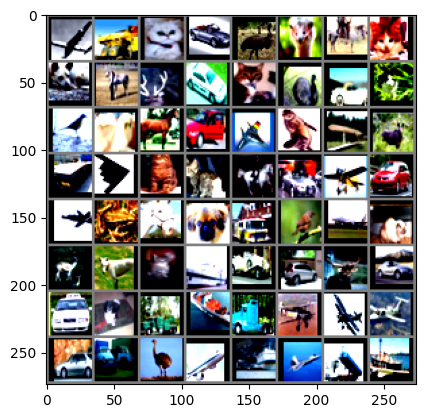

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:1s}' for j in range(batch_size)))

# Define a Supernet

In [ ]:
from hyperbox.networks.resnet import resnet18, resnet50
from torchvision import models

plane truck cat car bird bird horse cat dog horse deer car cat bird car cat bird dog horse car plane cat plane deer truck plane cat cat horse car plane car plane frog horse dog truck bird plane cat deer dog cat ship car car deer car car dog truck ship truck plane plane plane car truck bird plane ship plane truck ship


In [ ]:
from hyperbox.mutator import DartsMutator, RandomMutator, OnehotMutator
net = resnet18(ratios=[0.5, 0.8, 1], num_classes=10)
# net = models.resnet50()
# dm = DartsMutator(net)
# dm = RandomMutator(net)
dm = OnehotMutator(net)
dm.reset()
print(dm._cache)

{'layer4_outplanes1': tensor([0., 0., 1.], grad_fn=<AddBackward0>), 'layer1_inplanes': tensor([0., 0., 1.], grad_fn=<AddBackward0>), 'layer1_outplanes0': tensor([1., 0., 0.], grad_fn=<AddBackward0>), 'layer1_outplanes1': tensor([0., 1., 0.], grad_fn=<AddBackward0>), 'layer2_outplanes0': tensor([0., 1., 0.], grad_fn=<AddBackward0>), 'layer2_outplanes1': tensor([1., 0., 0.], grad_fn=<AddBackward0>), 'layer3_outplanes0': tensor([0., 1., 0.], grad_fn=<AddBackward0>), 'layer3_outplanes1': tensor([1., 0., 0.], grad_fn=<AddBackward0>), 'layer4_outplanes0': tensor([1., 0., 0.], grad_fn=<AddBackward0>)}


# Optimizers

In [ ]:
w_opt = torch.optim.SGD(net.parameters(),  lr=0.01, momentum=0.9, weight_decay=5e-4)
a_opt = torch.optim.Adam(dm.parameters(), lr=3e-4, weight_decay=1e-3)
# a_opt = None

# Train & Test Function

In [ ]:
import copy

def unrolled_backward(model, mutator, criterion, w_opt, a_opt, train_x, train_y, val_x, val_y):
    backup_params = copy.deepcopy(tuple(model.parameters()))

    # do virtual step on training data
    # _compute_virtual_model 
    lr = w_opt.param_groups[0]["lr"]
    momentum = w_opt.param_groups[0]["momentum"]
    weight_decay = w_opt.param_groups[0]["weight_decay"]
    mutator.reset()
    output = model(train_x)
    w_loss = criterion(output, train_y)
    gradients = torch.autograd.grad(w_loss, model.parameters())
    with torch.no_grad():
        for w, g in zip(model.parameters(), gradients):
            m = w_opt.state[w].get("momentum_buffer", 0.)
            w = w - lr * (momentum * m + g + weight_decay * w)

    # calculate unrolled loss on validation data
    # keep gradients for model here for compute hessian
    mutator.reset()
    output = model(val_x)
    a_loss = criterion(output, val_y)
    w_model, w_ctrl = tuple(model.parameters()), tuple(mutator.parameters())
    w_grads = torch.autograd.grad(a_loss, w_model + w_ctrl)
    d_model, d_ctrl = w_grads[:len(w_model)], w_grads[len(w_model):]

    # compute hessian and final gradients
    _restore_weights(model, backup_params)
    norm = torch.cat([w.view(-1) for w in d_model]).norm()
    eps = 0.01 / norm
    if norm < 1E-8:
        print("In computing hessian, norm is smaller than 1E-8, cause eps to be %.6f.", norm.item())

    dalphas = []
    for e in [eps, -2. * eps]:
        # w+ = w + eps*dw`, w- = w - eps*dw`
        with torch.no_grad():
            for p, d in zip(model.parameters(), d_model):
                p += e * d

        mutator.reset()
        output = model(train_x)
        a_loss = criterion(output, train_y)
        dalphas.append(torch.autograd.grad(a_loss, mutator.parameters()))

    dalpha_pos, dalpha_neg = dalphas  # dalpha { L_trn(w+) }, # dalpha { L_trn(w-) }
    hessian = [(p - n) / 2. * eps for p, n in zip(dalpha_pos, dalpha_neg)]

    # hessian = _compute_hessian(backup_params, d_model, train_x, train_y)
    with torch.no_grad():
        for param, d, h in zip(w_ctrl, d_ctrl, hessian):
            # gradient = dalpha - lr * hessian
            param.grad = d - lr * h

    # restore weights
    _restore_weights(model, backup_params)

def _restore_weights(model, backup_params):
    with torch.no_grad():
        for param, backup in zip(model.parameters(), backup_params):
            param.copy_(backup)


In [ ]:
def train(train_loader, val_loader, model, mutator, criterion, w_opt, a_opt, is_rolled, device, epoch):
    model.train()
    for batch_idx, ((train_x, train_y), (val_x, val_y)) in enumerate(zip(train_loader, val_loader)):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)
        val_x, val_y = val_x.to(device, non_blocking=True), val_y.to(device, non_blocking=True)

        # update architecture
        if a_opt is not None:
            a_opt.zero_grad(set_to_none=True)
            if is_rolled:
                unrolled_backward()
            else:
                mutator.reset()
                output = model(val_x)
                a_loss = criterion(output, val_y)
                a_loss.backward()
            a_opt.step()

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = model(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(train_x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), w_loss.item()))
        

In [ ]:
def validate(loader, model, criterion, device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (x, y) in enumerate(loader):
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            output = model(x)
            loss = criterion(output, y)
            test_loss += loss.item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(loader.dataset)
    test_acc = 100. * correct / len(loader.dataset)

    if verbose:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(loader.dataset), test_acc))
    return test_loss, test_acc

# Search

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
history = {}
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
model = net.to(device)
mutator = dm.to(device)
is_rolled = False
for epoch in range(1, 50):
    train(train_loader, val_loader, model, mutator, criterion, w_opt, a_opt, is_rolled, device, epoch)
    mask = mutator.export()
    mutator.sample_by_mask(mask)
    # arch = model.arch
    val_loss, val_acc = validate(test_loader, model, criterion, device, verbose=True)
    print(f"acc={val_acc} loss={val_loss}")
    # print(f"{arch} acc={val_acc} loss={val_loss}")
    torch.save(model.state_dict(), 'resnet18_supernet.pt')
    torch.save(mutator.state_dict(), 'resnet18_darts.pt')

Train Epoch: 1 [6336/25000 (25%)]	Loss: 0.417203
Train Epoch: 1 [12736/25000 (51%)]	Loss: 0.415776
Train Epoch: 1 [19136/25000 (76%)]	Loss: 0.659723

Test set: Average loss: 0.0088, Accuracy: 8126/10000 (81%)

acc=81.26 loss=0.008829692901670932
Train Epoch: 2 [6336/25000 (25%)]	Loss: 0.380100
Train Epoch: 2 [12736/25000 (51%)]	Loss: 0.591265
Train Epoch: 2 [19136/25000 (76%)]	Loss: 0.292570

Test set: Average loss: 0.0124, Accuracy: 7469/10000 (75%)

acc=74.69 loss=0.012360220152139664
Train Epoch: 3 [6336/25000 (25%)]	Loss: 0.231393
Train Epoch: 3 [12736/25000 (51%)]	Loss: 0.218499
Train Epoch: 3 [19136/25000 (76%)]	Loss: 0.375723

Test set: Average loss: 0.0116, Accuracy: 7620/10000 (76%)

acc=76.2 loss=0.011556060856580735
Train Epoch: 4 [6336/25000 (25%)]	Loss: 0.392508
Train Epoch: 4 [12736/25000 (51%)]	Loss: 0.234236
Train Epoch: 4 [19136/25000 (76%)]	Loss: 0.434004

Test set: Average loss: 0.0107, Accuracy: 7729/10000 (77%)

acc=77.29 loss=0.010662431418895722
Train Epoch: 5 [6

# Export the best model

In [ ]:
mask = mutator.export()
subnet = super(model.__class__, model).build_subnet(mask).to(device)
val_loss, val_acc = validate(test_loader, model, criterion, device, verbose=True)
# print(subnet)


Test set: Average loss: 0.0074, Accuracy: 8657/10000 (87%)



## Finetune the Exported Subnet

In [ ]:
def finetune(train_loader, model, criterion, w_opt, device, epoch):
    model.train()
    for batch_idx, (train_x, train_y) in enumerate(train_loader):
        train_x, train_y = train_x.to(device, non_blocking=True), train_y.to(device, non_blocking=True)

        # update weights
        w_opt.zero_grad(set_to_none=True)
        with torch.no_grad():
            mutator.reset()
        output = model(train_x)
        w_loss = criterion(output, train_y)
        w_loss.backward()
        w_opt.step()

        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(train_x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), w_loss.item()))
        

In [ ]:
# w_opt = torch.optim.Adam(subnet.parameters(),  lr=0.001, weight_decay=5e-4)
w_opt = torch.optim.SGD(subnet.parameters(),  lr=0.001, momentum=0.9, weight_decay=5e-4)
for epoch in range(1, 30):
    finetune(all_train_loader, subnet, criterion, w_opt, device, epoch)
    # arch = model.arch
    val_loss, val_acc = validate(test_loader, subnet, criterion, device, verbose=True)
    print(f"acc={val_acc} loss={val_loss}")
    # print(f"{arch} acc={val_acc} loss={val_loss}")
    torch.save(model.state_dict(), 'resnet18_subnet.pt')

Train Epoch: 1 [6336/50000 (13%)]	Loss: 0.190795
Train Epoch: 1 [12736/50000 (25%)]	Loss: 0.258265
Train Epoch: 1 [19136/50000 (38%)]	Loss: 0.234407
Train Epoch: 1 [25536/50000 (51%)]	Loss: 0.293066
Train Epoch: 1 [31936/50000 (64%)]	Loss: 0.170037
Train Epoch: 1 [38336/50000 (77%)]	Loss: 0.282725
Train Epoch: 1 [44736/50000 (89%)]	Loss: 0.236831

Test set: Average loss: 0.0045, Accuracy: 9051/10000 (91%)

acc=90.51 loss=0.004529080426692963
Train Epoch: 2 [6336/50000 (13%)]	Loss: 0.239414
Train Epoch: 2 [12736/50000 (25%)]	Loss: 0.205366
Train Epoch: 2 [19136/50000 (38%)]	Loss: 0.166869
Train Epoch: 2 [25536/50000 (51%)]	Loss: 0.235801
Train Epoch: 2 [31936/50000 (64%)]	Loss: 0.150879
Train Epoch: 2 [38336/50000 (77%)]	Loss: 0.155645
Train Epoch: 2 [44736/50000 (89%)]	Loss: 0.223760

Test set: Average loss: 0.0043, Accuracy: 9085/10000 (91%)

acc=90.85 loss=0.004343890618532896
Train Epoch: 3 [6336/50000 (13%)]	Loss: 0.296621
Train Epoch: 3 [12736/50000 (25%)]	Loss: 0.367816
Train Epo

In [ ]:
size_original = sum([p.numel() for p in model.parameters()])
size_subnet = sum([p.numel() for p in subnet.parameters()])
print(size_original, size_subnet, f"compressed by {(1-size_subnet/size_original)*100}%.")

11534016 8146016 compressed by 29.37398387517409%.
